# Data Mining (KEN4113) #
## Lab 3: Classification ##

Konstantin Sandfort
i6255681

In [2]:
# Imports
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

In [3]:
# Import data

# Training Data
X = pd.read_csv('caravan.csv')
y = X.iloc[:, -1]
X = X.drop(columns=['CARAVAN POLICY'])

pd.set_option('display.max_columns', None)

In [4]:
# --- Step 1: Preprocessing ---

# One-hot-encoding of l0 and l2
def ohe(df, col_name, label):
    cols = pd.get_dummies(df,
                          prefix=label,
                          dtype=int,
                          columns=[col_name],
                          drop_first=False)
    return cols

X_ohe = ohe(X, 'Customer Subtype', 'l0')
X_ohe = ohe(X_ohe, 'Customer main type', 'l2')

# Standardize data (scaling and centering)
X_ohe_std = preprocessing.StandardScaler().fit_transform(X_ohe)

In [5]:
# Model validation
# Source: https://medium.com/analytics-vidhya/model-validation-for-classification-5ff4a0373090
def display_confusion_matrix(y_actual, y_pred):
    matrix = confusion_matrix(y_pred, y_actual)
    
    matrix = pd.DataFrame(matrix, columns=['Actually No Caravan Insurance', 'Actually Caravan Insurance'], 
                                     index=['Predict No Caravan Insurance', 'Predict Caravan Insurance'])
    sns.heatmap(matrix, annot=True, cmap='magma', fmt='d')

In [6]:
# Split data into training-set and test-set
X_train, X_test, y_train, y_test = train_test_split(X_ohe_std, y, test_size=0.5, random_state=0)

/home/konstantin/PycharmProjects/data_mining_course/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 accuracy score: 0.9361044314668499


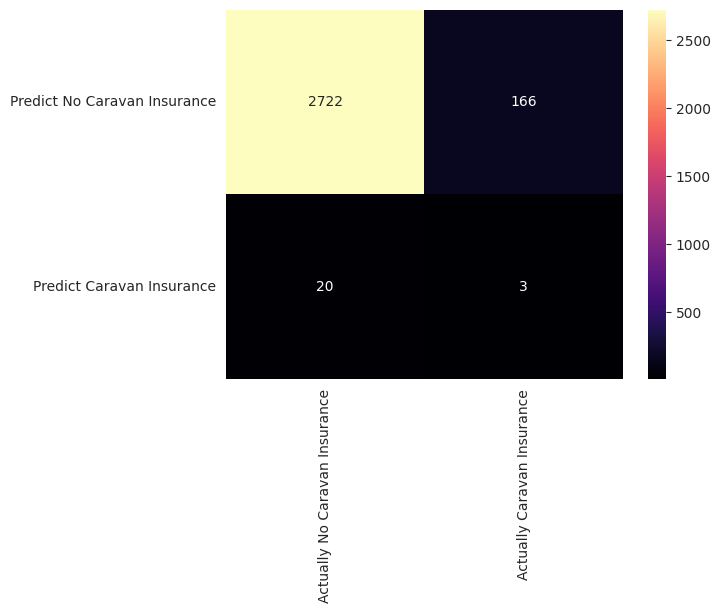

In [7]:
# Model 1: Logistical Regression with all features

log_reg_v1_model = LogisticRegression(verbose=False, penalty=None)
log_reg_v1_model.fit(X=X_train, y=y_train)
pred_1 = log_reg_v1_model.predict(X_test)
score_1 = log_reg_v1_model.score(X=X_test, y=y_test)
print(f'Model 1 accuracy score: {score_1}')

display_confusion_matrix(y_test, pred_1)

/home/konstantin/PycharmProjects/data_mining_course/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[['Rented house' 8.345407757648896]
 ['Home owners' 8.20352576579866]
 ['Private health insurance' 5.789441728413739]
 ['National Health Service' 5.598901601046142]
 ['l2_6' 4.92628566261931]
 ['Contribution private third party insurance' 0.750136255879636]
 ['Number of private third party insurance' 0.646380010574453]
 ['Contribution car policies' 0.6419221584465467]
 ['l2_10' 0.4723753283831541]
 ['Number of boat policies' 0.43788131232179955]
 ['Farmer' 0.4001515700040164]
 ['Contribution fire policies' 0.3812969153834383]
 ['Married' 0.3385796449746436]
 ['Other relation' 0.3168402905229016]
 ['Contribution boat policies' 0.27915495472909324]
 ['No religion' 0.2017255704859539]
 ['Purchasing power class' 0.17696783264842997]
 ['Social class D' 0.16587842990985088]
 ['Number of re policies' 0.15794367257182473]
 ['High level education' 0.15445501615072765]
 ['l0_12' 0.15040668768993004]
 ['l2_1' 0.13979727034855233]
 ['Medium level education' 0.12878504451786732]
 ['l0_8' 0.12195984

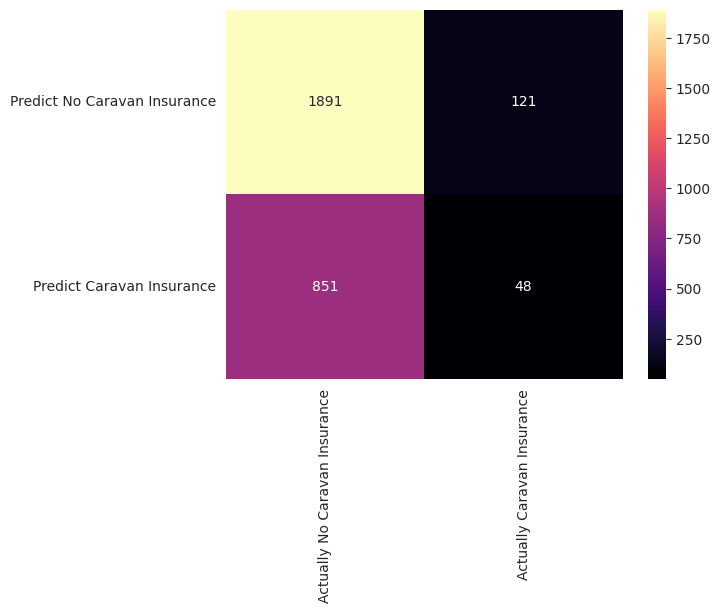

In [8]:
# --- Step 2: Feature Selection
# Univariate Feature Selection

def univariate_feature_selection(df, y, k_f):
    selector = SelectKBest(f_classif, k=k_f)
    selected = selector.fit_transform(df, y)
    mask = selector.get_support()
    f = np.array(X_ohe.columns)
    col_names = f[mask]
    return selected, col_names

X_train_ufs, col_names_train = univariate_feature_selection(X_train, y_train, 40)
X_test_ufs, col_names_test = univariate_feature_selection(X_test, y_test, 40)

log_reg_v2_model = LogisticRegression(verbose=False, penalty=None)
log_reg_v2_model.fit(X=X_train_ufs, y=y_train)
prediction_2 = log_reg_v2_model.predict(X_test_ufs)


coefficients = log_reg_v2_model.coef_
features = np.transpose(np.vstack((col_names_train, np.abs(coefficients[0]))))
features_sorted = np.flip(features[features[:, 1].argsort()], axis=0)
print(features_sorted)

score_2 = log_reg_v2_model.score(X=X_test_ufs, y=y_test)
print(f'Model 2 accuracy score: {score_2}')

display_confusion_matrix(y_test, prediction_2)

Score 3: 0.9086224665063553
0.9086224665063553


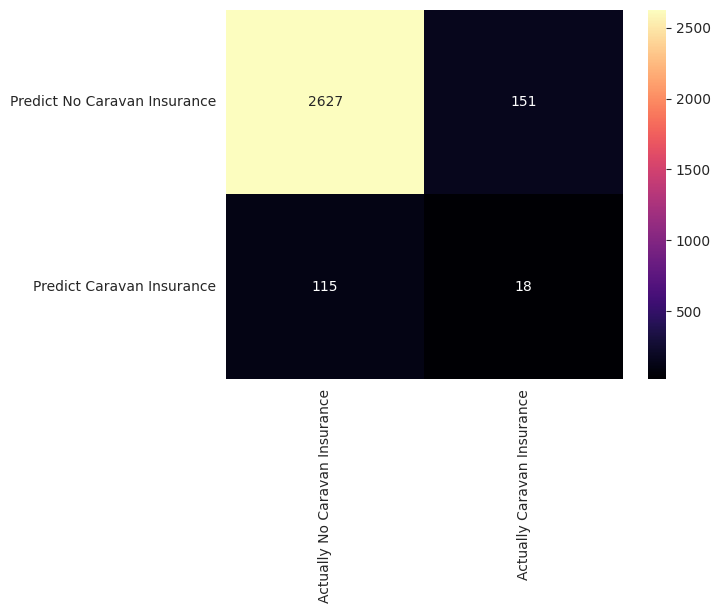

In [9]:
# Decision Tree Classification
# We use the original OHE data because the tree itself does feature selection
tree_model = tree.DecisionTreeClassifier(max_depth=12)
tree_model = tree_model.fit(X_train, y_train)
prediction_3 = tree_model.predict(X_test)
score_3 = tree_model.score(X_test, y_test)
print(f'Score 3: {score_3}')
display_confusion_matrix(y_test, prediction_3)
print(tree_model.score(X_test, y_test))

Score 4: 0.941944349020955


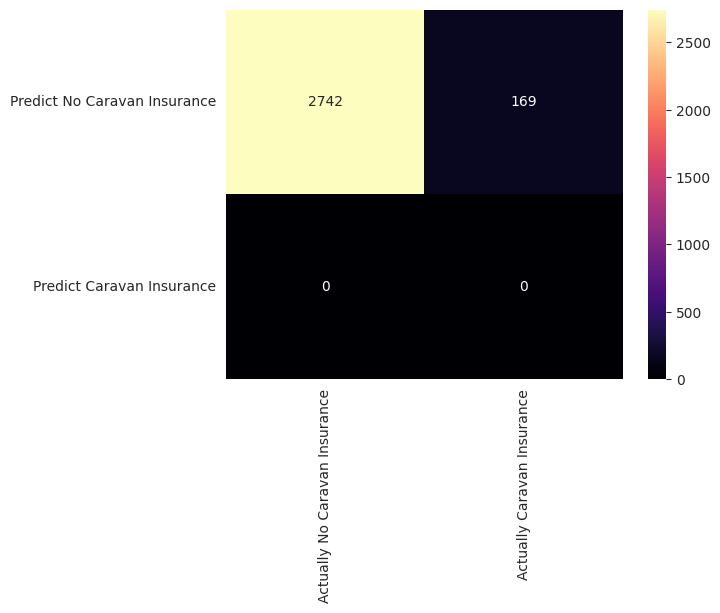

In [10]:
# KNN model
knn_model = KNeighborsClassifier(n_neighbors=20)
knn_model.fit(X_test_ufs, y_train)
prediction_4 = knn_model.predict(X_test_ufs)
score_4 = knn_model.score(X_test_ufs, y_test)
print(f'Score 4: {score_4}')
display_confusion_matrix(y_test, prediction_4)

0.941944349020955


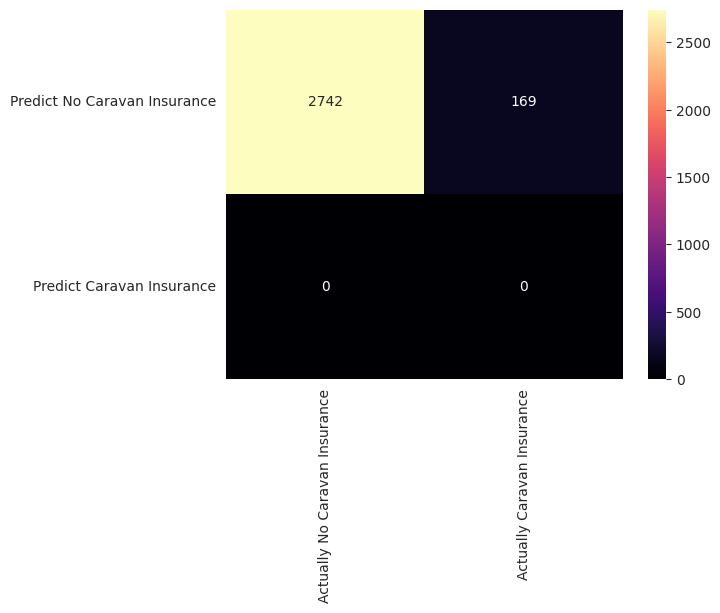

In [11]:
# Naive Bayes model - very poor performance
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_ufs, y_train)
prediction_5 = naive_bayes_model.predict(X_test_ufs)
score_5 = naive_bayes_model.score(X_test_ufs, y_test)
print(score_5)
display_confusion_matrix(y_test, prediction_5)

0.8859498454139471


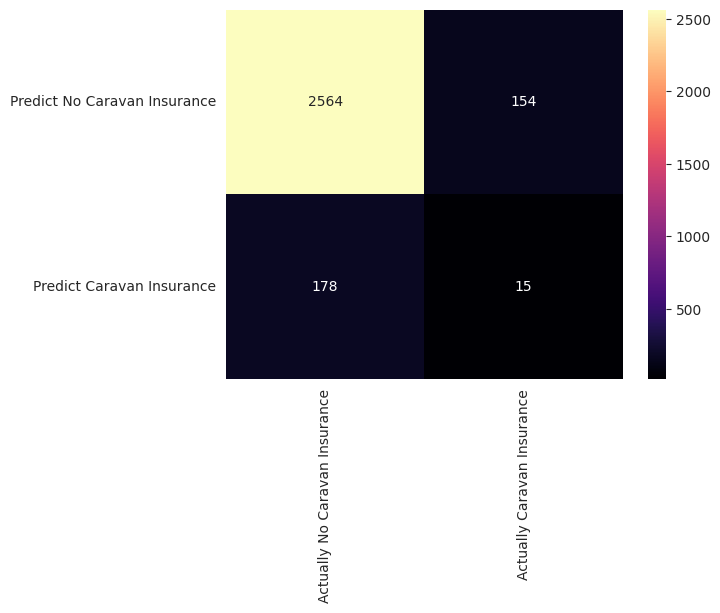

In [12]:
clf = GradientBoostingClassifier(n_estimators=4, learning_rate=0.97, max_depth=50, random_state=0)
clf.fit(X_train_ufs, y_train)
score_6 = clf.score(X_test_ufs, y_test)
prediction_6 = clf.predict(X_test_ufs)
display_confusion_matrix(y_test, prediction_6)
print(score_6)

In [13]:
# Get predictions from the final model

data_test_final = pd.read_csv('caravanTest.csv')
y_test_final = data_test_final.iloc[:, -1]
data_test_final = data_test_final.drop(columns=['CARAVAN POLICY'])
data_test_final_ohe = ohe(data_test_final, 'Customer Subtype', 'l0')
data_test_final_ohe = ohe(data_test_final_ohe, 'Customer main type', 'l2')
data_test_final_ohe_ufs, col_names_train = univariate_feature_selection(X_train, y_train, 40)

log_reg_v2_model.predict(data_test_final_ohe_ufs)

array([0, 0, 0, ..., 0, 0, 0])